# Visualizing KG statistics
In this notebook, we will be visualizing statistics about the KG generated with DyGIE++, as well as statistics about the corpus from which the graphs were generated: number of docs, words per doc, mean/median number of predictions (entities and relations) for each model, number of unique entities overall, mean/median number of predictions for each doc, as well as plotting the softmax scores for predictions from each model.
<br><br>
Due to Jupyter's memory limitations, each section with its corresponding markdown explanations will only have function definitions. The function definitions will be applied to one dataset at a time at the end of the notebook, deleting the unused data between each run to avoid saturating the memory allocation.

In [1]:
import pandas as pd
import jsonlines

from statistics import mean, median
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading in the data 
----------------------------

In [2]:
def read_predictions(path):
    """
    Read in the dygiepp prediction file.
    
    parameters:
        path, str: path to dygiepp output file
        
    returns: 
        results, list of dict: list of prediction dicts
    """
    results = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            results.append(obj)
    
    return results

## Application corpus statistics
---------------------
### Number of docs
There is one json object in the prediction file per document. The same set of docs was used to build both graphs.

In [3]:
def get_num_docs(results):
    """
    Helper for get_corpus_stats.
    """
    print(f'{len(results)} documents were used to build the graphs.\n')

### Total sentences & sentences per doc, total words & words per doc
Each object contains a list of lists, where each internal list is a sentence, and list elements are sentence tokens. This includes periods -- will not subtract these from the count, since the model considers them to be words.

In [4]:
def get_sentence_stats(results, dataset_name):
    """
    Helper for get_corpus_stats
    """
    # Get number of sentences in each doc
    num_sent_in_docs = []
    for doc in results:
        num_sent_in_docs.append(len(doc['sentences']))

    # Calculate stats
    total_sent = sum(num_sent_in_docs)
    mean_sent_per_doc = mean(num_sent_in_docs)
    median_sent_per_doc = median(num_sent_in_docs)
    largest_doc = max(num_sent_in_docs)
    smallest_doc = min(num_sent_in_docs)

    print(f'{total_sent} sentences were used to build the graphs using the {dataset_name} model.')
    print(f'There are an average of {mean_sent_per_doc:.2f} sentences per doc, and a median value of {median_sent_per_doc} sentences per doc.')
    print(f'The largest doc has {largest_doc} sentences, and the smallest doc has {smallest_doc}.\n')
    
    return num_sent_in_docs

In [5]:
def get_word_stats(results, dataset_name):
    """
    Helper for get_corpus_stats.
    """
    # Get number of words in each doc
    num_words_in_docs = []
    for doc in results:
        num_words = 0
        for sentence in doc['sentences']:
            num_words += len(sentence)
        num_words_in_docs.append(num_words)

    # Calculate stats
    total_words = sum(num_words_in_docs)
    mean_words_per_doc = mean(num_words_in_docs)
    median_words_per_doc = median(num_words_in_docs)
    longest_doc = max(num_words_in_docs)
    shortest_doc = min(num_words_in_docs)

    print(f'There are a total of {total_words} words in the documents used to build the graph using the {dataset_name} model.')
    print(f'There are an average of {mean_words_per_doc:.2f} words per doc, and a median value of {median_words_per_doc}')
    print(f'The longest doc has {longest_doc} words, and the shortest doc has {shortest_doc}.\n')
    
    return num_words_in_docs

In [6]:
def get_words_per_sent(results):
    """
    Helper for get_corpus_stats.
    """
    # Words per sentence
    num_words_in_sent = []
    for doc in results:
        for sentence in doc['sentences']:
            num_words_in_sent.append(len(sentence))
            
    return num_words_in_sent

In [7]:
def get_chars_per_sent(results):
    """
    Get the number of non-space characters per sentence.
    """
    num_chars_in_sent = []
    for doc in results:
        for sentence in doc['sentences']:
            sent_str = ''.join(sentence)
            num_chars = len(sent_str)
            num_chars_in_sent.append(num_chars)
            
    return num_chars_in_sent

In [8]:
def get_corpus_stats(results, dataset_name):
    """
    Get corpus stats.
    
    parameters: 
        results, list of dict: prediction results from dygiepp 
        dataset_name, str: name of the dataset
    
    returns:
        (num_sents, num_words, num_words_in_sent), tuple of list of int
    """
    get_num_docs(results)
    num_sents = get_sentence_stats(results, dataset_name)
    num_words = get_word_stats(results, dataset_name)
    num_words_in_sent = get_words_per_sent(results)
    
    return (num_sents, num_words, num_words_in_sent)

#### Plotting
Plotting boxplots for number of words and sentences per document

In [9]:
def plot_corpus_sents(num_sent_in_docs):
    """
    Plot the number of sentences in each document.
    """
    # Sentences per document 
    ax = sns.violinplot(data=num_sent_in_docs)
    ax.set_title('Number of sentences in each document')
    ax.set_ylabel('Number of sentences')

In [10]:
def plot_corpus_words(num_words_in_docs):
    """
    Plot the number of words in each document
    """
    # Words per document 
    ax = sns.violinplot(data=num_words_in_docs)
    ax.set_title('Number of words in each document')
    ax.set_ylabel('Number of words')

In [11]:
def plot_corpus_words_per_sent(num_words_in_sent):
    """
    Plot the number of words per sentence in the corpus.
    """        
    ax = sns.violinplot(data=num_words_in_sent)
    ax.set_title('Number of words per sentence')
    ax.set_ylabel('Number of words')

In [12]:
def plot_corpus_chars_per_sent(num_chars_per_sent):
    """
    Plot the unmber of characters in each sentence.
    """
    ax = sns.violinplot(data=num_chars_per_sent)
    ax.set_title('Number of characters per sentence')
    ax.set_ylabel('Number of characters')

## Graph statistics
----------------------
### Mean & median numbers of predictions, overall and per doc
We want to see how many predictions each model made, overall and on a per doc basis. Will get numbers as well as making plots.


In [13]:
def get_pred_ent_stats(pred_list, model_name):
    """
    Get prediction statistics for model output for NER only. 
    
    parameters:
        pred_list, list of dict: json objects from dygiepp output
        model_name, str: name of model. Should have suffix of '_ents'
        
    returns:
        stats_df, df: columns are model_name | stats...
    """
    abs_num_preds = []
    num_ents_norm_sents = []
    num_ents_norm_words = []
    for doc in pred_list:

        num_preds = sum([len(sentence) for sentence in doc['predicted_ner']])
        num_sents = len(doc['sentences'])
        num_words = sum([len(sentence) for sentence in doc['sentences']])

        abs_num_preds.append(num_preds)
        num_ents_norm_sents.append(num_preds/num_sents)
        num_ents_norm_words.append(num_preds/num_words)

    ### Statistics
    stats = {}
    stats['model_name'] = model_name
    stats['total_preds'] = sum(abs_num_preds)
    stats['mean_norm_sents'] = mean(num_ents_norm_sents)
    stats['mean_norm_words'] = mean(num_ents_norm_words)
    stats['median_norm_sents'] = median(num_ents_norm_sents)
    stats['median_norm_words'] = median(num_ents_norm_words)
    stats['least_norm_sents'] = min(num_ents_norm_sents)
    stats['least_norm_words'] = min(num_ents_norm_words)
    stats['greatest_norm_sents'] = max(num_ents_norm_sents)
    stats['greatest_norm_words'] = max(num_ents_norm_words)

    print(f'Total predictions: {stats["total_preds"]}\n')
    print(f'Mean predictions per doc, normalized by number of sentences: {stats["mean_norm_sents"]:.2f} predictions per sentence')
    print(f'Mean predictions per doc, normalized by number of words: {stats["mean_norm_words"]:.2f} predictions per word\n')
    print(f'Median predictions per doc, normalized by number of sentences: {stats["median_norm_sents"]:.2f} predictions per sentence')
    print(f'Median predictions per doc, normalized by number of words: {stats["median_norm_words"]:.2f} predictions per word\n')
    print(f'Least number of predictions per doc, normalized by number of sentences: {stats["least_norm_sents"]:.2f} predictions per sentence')
    print(f'Least number of predictions per doc, normalized by number of words: {stats["least_norm_words"]:.2f} predictions per word\n')
    print(f'Greatest number of predictions per doc, normalized by number of sentences: {stats["greatest_norm_sents"]:.2f} predictions per sentence')
    print(f'Greatest number of predictions per doc, normalized by number of words: {stats["greatest_norm_words"]:.2f} predictions per word\n')

    for key, value in stats.items():
        stats[key] = [value]
    
    stats_df = pd.DataFrame(stats)
    
    return stats_df

In [14]:
# Relations (triples)
def get_pred_rels_stats(pred_list, model_name):
    """
    Get prediction statistics for model output for triples only. 
    
    parameters:
        pred_list, list of dict: json objects from dygiepp output
        model_name, str: name of model. Should have suffix of '_rels'
        
    returns:
        stats_df, df: columns are model_name | stats...
    """
    abs_num_preds = []
    num_rels_norm_sents = []
    num_rels_norm_words = []
    for doc in pred_list:

        num_preds = sum([len(sentence) for sentence in doc['predicted_relations']])
        num_sents = len(doc['sentences'])
        num_words = sum([len(sentence) for sentence in doc['sentences']])

        abs_num_preds.append(num_preds)
        num_rels_norm_sents.append(num_preds/num_sents)
        num_rels_norm_words.append(num_preds/num_words)

    ### Statistics
    stats = {}
    stats['model_name'] = model_name
    stats['total_preds'] = sum(abs_num_preds)
    stats['mean_norm_sents'] = mean(num_rels_norm_sents)
    stats['mean_norm_words'] = mean(num_rels_norm_words)
    stats['median_norm_sents'] = median(num_rels_norm_sents)
    stats['median_norm_words'] = median(num_rels_norm_words)
    stats['least_norm_sents'] = min(num_rels_norm_sents)
    stats['least_norm_words'] = min(num_rels_norm_words)
    stats['greatest_norm_sents'] = max(num_rels_norm_sents)
    stats['greatest_norm_words'] = max(num_rels_norm_words)

    print(f'Total predictions: {stats["total_preds"]}\n')
    print(f'Mean predictions per doc, normalized by number of sentences: {stats["mean_norm_sents"]:.2f} predictions per sentence')
    print(f'Mean predictions per doc, normalized by number of words: {stats["mean_norm_words"]:.2f} predictions per word\n')
    print(f'Median predictions per doc, normalized by number of sentences: {stats["median_norm_sents"]:.2f} predictions per sentence')
    print(f'Median predictions per doc, normalized by number of words: {stats["median_norm_words"]:.2f} predictions per word\n')
    print(f'Least number of predictions per doc, normalized by number of sentences: {stats["least_norm_sents"]:.2f} predictions per sentence')
    print(f'Least number of predictions per doc, normalized by number of words: {stats["least_norm_words"]:.2f} predictions per word\n')
    print(f'Greatest number of predictions per doc, normalized by number of sentences: {stats["greatest_norm_sents"]:.2f} predictions per sentence')
    print(f'Greatest number of predictions per doc, normalized by number of words: {stats["greatest_norm_words"]:.2f} predictions per word\n')

    for key, value in stats.items():
        stats[key] = [value]
    
    stats_df = pd.DataFrame(stats)
    
    return stats_df

#### Plotting
Making two plots, one for normalization by sentences and another for normalization by words. There will be 4 items on each plot, two for each model, one rels and one ents. Each dot in the plot represents one document. Swarmplot was too computationally intensive and too big to be interpretable, so there aren't actually dots -- would have preferred to do violin plots here, but they don't come out as interpretable either for some reason here.

In [15]:
def get_plot_data(pred_list, model_name):
    """
    Get data for plots.
    
    paramters:
        pred_list, list of dict: list of json objects from dygiepp output
        model_name, str: name of model (no suffix)
        
    returns:
        plot_data, dict: keys are f'{model_name}_rels_{normalization_type}', 
            f'{model_name}_ents_{normalization_type}', values are lists of data points
    """
    # Get entity data
    num_ents_norm_sents = []
    num_ents_norm_words = []
    
    for doc in pred_list:

        num_preds = sum([len(sentence) for sentence in doc['predicted_ner']])
        num_sents = len(doc['sentences'])
        num_words = sum([len(sentence) for sentence in doc['sentences']])

        num_ents_norm_sents.append(num_preds/num_sents)
        num_ents_norm_words.append(num_preds/num_words)
        
    # Get relation data
    num_rels_norm_sents = []
    num_rels_norm_words = []
    
    for doc in pred_list:

        num_preds = sum([len(sentence) for sentence in doc['predicted_relations']])
        num_sents = len(doc['sentences'])
        num_words = sum([len(sentence) for sentence in doc['sentences']])

        num_rels_norm_sents.append(num_preds/num_sents)
        num_rels_norm_words.append(num_preds/num_words)
        
    # Make dict
    plot_data = {f'{model_name}_ents_norm_sents':num_ents_norm_sents,
                f'{model_name}_ents_norm_words':num_ents_norm_words,
                f'{model_name}_rels_norm_sents':num_rels_norm_sents,
                f'{model_name}_rels_norm_words':num_rels_norm_words}
    
    return plot_data

In [16]:
def get_plot_data_no_rels(pred_list, model_name):
    """
    Get data for plots.
    
    paramters:
        pred_list, list of dict: list of json objects from dygiepp output
        model_name, str: name of model (no suffix)
        
    returns:
        plot_data, dict: keys are f'{model_name}_ents_{normalization_type}', values are lists of data points
    """
    # Get entity data
    num_ents_norm_sents = []
    num_ents_norm_words = []
    
    for doc in pred_list:

        num_preds = sum([len(sentence) for sentence in doc['predicted_ner']])
        num_sents = len(doc['sentences'])
        num_words = sum([len(sentence) for sentence in doc['sentences']])

        num_ents_norm_sents.append(num_preds/num_sents)
        num_ents_norm_words.append(num_preds/num_words)
        
        
    # Make dict
    plot_data = {f'{model_name}_ents_norm_sents':num_ents_norm_sents,
                f'{model_name}_ents_norm_words':num_ents_norm_words}
    
    return plot_data

### Number of unique entities
Want to see how many of the total predicted entities (from ner and relations) are unique.

### Softmax scores
Softmax scores represent how confident the model is about its predictions. Unclear whether this is the confidence in predicting the span as an entity or in predicting its type. Each "dot" in the plot represents one prediction.

In [17]:
def get_softmax(pred_list):
    """
    Gets the softmax scores for a model's predictions of entities and relations.
    
    parameters:
        pred_list, list of dict: dygiepp output
        
    returns:
        (ents_softmax, rels_softmax), two lists: softmax scores for predictions of entities and relations, 
            respectively.
    """
    # Get entity prediction softmax scores 
    ents_softmax = []
    for doc in pred_list:
        for sentence in doc['predicted_ner']:
            for ent_pred in sentence:
                ents_softmax.append(ent_pred[-1])
                
    # Get relation prediction softmax scores
    rels_softmax = []
    for doc in pred_list:
        for sentence in doc['predicted_relations']:
            for rel_pred in sentence:
                rels_softmax.append(rel_pred[-1])
                
    return ents_softmax, rels_softmax

In [18]:
def get_softmax_no_rels(pred_list):
    """
    Gets the softmax scores for a model's predictions of entities and relations.
    
    parameters:
        pred_list, list of dict: dygiepp output
        
    returns:
        ents_softmax, list: softmax scores for predictions of entities
    """
    # Get entity prediction softmax scores 
    ents_softmax = []
    for doc in pred_list:
        for sentence in doc['predicted_ner']:
            for ent_pred in sentence:
                ents_softmax.append(ent_pred[-1])
   
    return ents_softmax

## Applying functions
---------------------
Here, we'll apply the above functions to get statistics and plots about the corpus and model predictions. For code that requires the raw prediction datasets, the first part of this section will be split into three, one for each dataset, and datasets wil be deleted after they are used. Then, the remainder (more memory efficient) plotting data will be used to make the combined plots about all three datasets.

### SciERC (with coref)

#### Reading in the data:

In [20]:
results = read_predictions('../data/first_manuscript_data/dygiepp/pretrained_output/withCoref/scierc/noPunct_SciERC_predictions.jsonl')

#### Getting corpus statistics: 
Since the corpus is identical across models, we'll get corpus statistics here.

In [20]:
num_sents, num_words, num_word_in_sent = get_corpus_stats(results, 'scierc')

8000 documents were used to build the graphs.

77719 sentences were used to build the graphs using the scierc model.
There are an average of 9.71 sentences per doc, and a median value of 10.0 sentences per doc.
The largest doc has 32 sentences, and the smallest doc has 1.

There are a total of 1700963 words in the documents used to build the graph using the scierc model.
There are an average of 212.62 words per doc, and a median value of 212.0
The longest doc has 621 words, and the shortest doc has 7.



In [21]:
num_chars_per_sent = get_chars_per_sent(results)

In [22]:
# Write out corpus statistics to use with gibberish generator 
file_names = {'sents_per_doc.txt':num_sents, 'chars_per_sent.txt':num_chars_per_sent}

for file_name, stat_list in file_names.items():
    print(file_name)
    df = pd.DataFrame(stat_list)
    df.to_csv(f'../data/first_manuscript_data/gibberish_data/{file_name}', index=False, header=None)

sents_per_doc.txt
chars_per_sent.txt


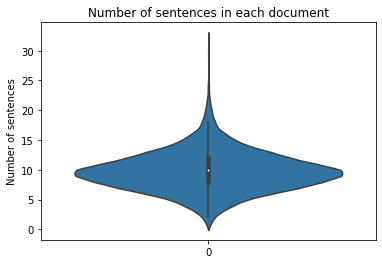

In [23]:
plot_corpus_sents(num_sents)

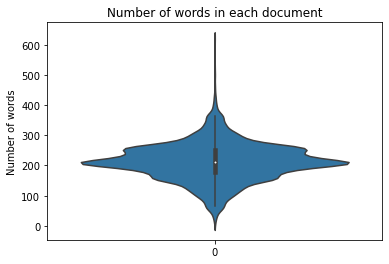

In [24]:
plot_corpus_words(num_words)

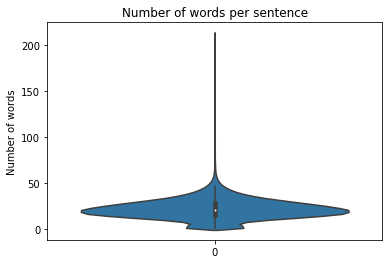

In [25]:
plot_corpus_words_per_sent(num_word_in_sent)

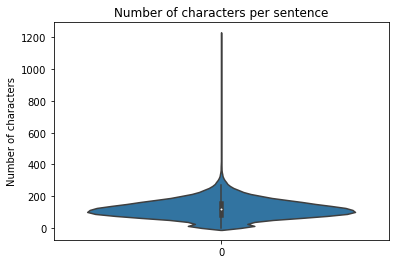

In [26]:
plot_corpus_chars_per_sent(num_chars_per_sent)

#### Getting gibberish corpus statistics 
Here, we'll also get the corpus statistics for the gibberish corpus to make sure their distributions look similar to those for the real corpus plotted above.

In [ ]:
gibberish_data = read_predictions('/mnt/home/lotrecks/Shiu_lab/knowledge-graph/data/first_manuscript_data/dygiepp/prepped_data/gibberishAll_dygiepp_formatted_data_scierc.jsonl')

In [ ]:
num_sents_gib, num_words_gib, num_word_in_sent_gib = get_corpus_stats(gibberish_data, 'scierc_gib')

In [ ]:
plot_corpus_sents(num_sents_gib)

In [ ]:
plot_corpus_words(num_words_gib)

In [ ]:
plot_corpus_words_per_sent(num_word_in_sent_gib)

In [ ]:
num_chars_per_sent_gib = get_chars_per_sent(gibberish_data)

In [ ]:
plot_corpus_chars_per_sent(num_chars_per_sent_gib)

The means look similar enough that I'm satisfied with this!The shapes are a bit different, but I assume that's due to sampling with replacement amplifying the frequency of the lower numbers.

#### Getting per graph data:

In [21]:
scierc_ent_stats = get_pred_ent_stats(results, 'scierc')

Total predictions: 237206

Mean predictions per doc, normalized by number of sentences: 3.14 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.14 predictions per word

Median predictions per doc, normalized by number of sentences: 3.10 predictions per sentence
Median predictions per doc, normalized by number of words: 0.14 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 10.00 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.25 predictions per word



In [22]:
scierc_rels_stats = get_pred_rels_stats(results, 'scierc')

Total predictions: 65338

Mean predictions per doc, normalized by number of sentences: 0.87 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.04 predictions per word

Median predictions per doc, normalized by number of sentences: 0.78 predictions per sentence
Median predictions per doc, normalized by number of words: 0.04 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 5.00 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.28 predictions per word



In [23]:
scierc_plot_data = get_plot_data(results, 'scierc')

#### Getting softmax scores:

In [24]:
scierc_ents_softmax, scierc_rels_softmax = get_softmax(results)

### ACE05 (naturally lightweight)

#### Reading in the data:

In [25]:
results = read_predictions('../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/ace05/noPunct_ACE05_predictions.jsonl')

#### Getting per graph data:

In [26]:
ace05_ent_stats = get_pred_ent_stats(results, 'ace05')

Total predictions: 82670

Mean predictions per doc, normalized by number of sentences: 1.09 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.05 predictions per word

Median predictions per doc, normalized by number of sentences: 1.00 predictions per sentence
Median predictions per doc, normalized by number of words: 0.05 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 5.10 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.20 predictions per word



In [27]:
ace05_rels_stats = get_pred_rels_stats(results, 'ace05')

Total predictions: 1040

Mean predictions per doc, normalized by number of sentences: 0.01 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.00 predictions per word

Median predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Median predictions per doc, normalized by number of words: 0.00 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 1.50 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.08 predictions per word



In [28]:
ace05_plot_data = get_plot_data(results, 'ace05')

#### Getting softmax scores:

In [29]:
ace05_ents_softmax, ace05_rels_softmax = get_softmax(results)

### SciERC (lightweight)

#### Reading in the data: 

In [30]:
results = read_predictions('../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/scierc-light/SciERC_predictions.jsonl')

#### Getting per graph data:

In [31]:
scierc_light_ent_stats = get_pred_ent_stats(results, 'scierc_light')

Total predictions: 301015

Mean predictions per doc, normalized by number of sentences: 4.04 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.15 predictions per word

Median predictions per doc, normalized by number of sentences: 3.91 predictions per sentence
Median predictions per doc, normalized by number of words: 0.15 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 19.00 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.41 predictions per word



In [32]:
scierc_light_rels_stats = get_pred_rels_stats(results, 'scierc_light')

Total predictions: 112563

Mean predictions per doc, normalized by number of sentences: 1.49 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.06 predictions per word

Median predictions per doc, normalized by number of sentences: 1.00 predictions per sentence
Median predictions per doc, normalized by number of words: 0.04 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 41.93 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 2.38 predictions per word



In [33]:
scierc_light_plot_data = get_plot_data(results, 'scierc_light')

#### Getting softmax scores:

In [34]:
scierc_light_ents_softmax, scierc_light_rels_softmax = get_softmax(results)

### GENIA

In [35]:
results = read_predictions('../data/first_manuscript_data/dygiepp/pretrained_output/withCoref/genia/GENIA_predictions.jsonl')

#### Getting per graph data:

In [36]:
genia_ent_stats = get_pred_ent_stats(results, 'genia')

Total predictions: 68203

Mean predictions per doc, normalized by number of sentences: 0.95 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.04 predictions per word

Median predictions per doc, normalized by number of sentences: 0.78 predictions per sentence
Median predictions per doc, normalized by number of words: 0.03 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 5.17 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.24 predictions per word



In [37]:
genia_plot_data = get_plot_data_no_rels(results, 'genia')

#### Getting softmax scores:

In [38]:
genia_ents_softmax = get_softmax_no_rels(results)

### GENIA (lightweight)

In [39]:
results = read_predictions('../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/genia-light/GENIA_predictions.jsonl')

#### Getting per graph data:

In [40]:
genia_light_ent_stats = get_pred_ent_stats(results, 'genia_light')

Total predictions: 54658

Mean predictions per doc, normalized by number of sentences: 0.77 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.03 predictions per word

Median predictions per doc, normalized by number of sentences: 0.57 predictions per sentence
Median predictions per doc, normalized by number of words: 0.02 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 5.00 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.18 predictions per word



In [41]:
genia_light_plot_data = get_plot_data_no_rels(results, 'genia_light')

#### Getting softmax scores:

In [42]:
genia_light_ents_softmax = get_softmax_no_rels(results)

### MECHANIC (coarse)

In [43]:
results = read_predictions('../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/mechanic-coarse/noPunct_mechanic-coarse_predictions.jsonl')

#### Getting per graph data:

In [44]:
mechanic_coarse_ent_stats = get_pred_ent_stats(results, 'mechanic_coarse')

Total predictions: 204867

Mean predictions per doc, normalized by number of sentences: 2.89 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.12 predictions per word

Median predictions per doc, normalized by number of sentences: 2.82 predictions per sentence
Median predictions per doc, normalized by number of words: 0.12 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 10.33 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 0.29 predictions per word



In [45]:
mechanic_coarse_rels_stats = get_pred_rels_stats(results, 'mechanic_coarse')

Total predictions: 191708

Mean predictions per doc, normalized by number of sentences: 2.69 predictions per sentence
Mean predictions per doc, normalized by number of words: 0.11 predictions per word

Median predictions per doc, normalized by number of sentences: 2.14 predictions per sentence
Median predictions per doc, normalized by number of words: 0.09 predictions per word

Least number of predictions per doc, normalized by number of sentences: 0.00 predictions per sentence
Least number of predictions per doc, normalized by number of words: 0.00 predictions per word

Greatest number of predictions per doc, normalized by number of sentences: 70.83 predictions per sentence
Greatest number of predictions per doc, normalized by number of words: 2.24 predictions per word



In [46]:
mechanic_coarse_plot_data = get_plot_data(results, 'mechanic_coarse')

### Combined plots 

#### Prediction numbers
---------------------

[Text(0, 0, 'scierc'),
 Text(1, 0, 'ace05'),
 Text(2, 0, 'scierc_light'),
 Text(3, 0, 'genia'),
 Text(4, 0, 'genia_light'),
 Text(5, 0, 'mechanic_coarse')]

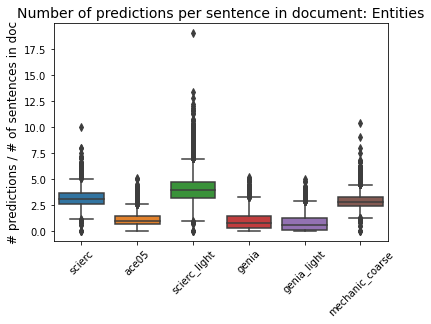

In [53]:
# Sentence plot entities
## Make dtaframe 
sentence_ents_df = pd.DataFrame({'scierc':scierc_plot_data['scierc_ents_norm_sents'],
                           'ace05':ace05_plot_data['ace05_ents_norm_sents'],
                           'scierc_light':scierc_light_plot_data['scierc_light_ents_norm_sents'], 
                           'genia':genia_plot_data['genia_ents_norm_sents'],
                           'genia_light':genia_light_plot_data['genia_light_ents_norm_sents'],
                           'mechanic_coarse':mechanic_coarse_plot_data['mechanic_coarse_ents_norm_sents']})
## Make plot
ax = sns.boxplot(data=sentence_ents_df)
ax.set_title('Number of predictions per sentence in document: Entities', fontsize=14)
ax.set_ylabel('# predictions / # of sentences in doc', fontsize=12)
ax.set_xticklabels(sentence_ents_df.columns.values.tolist(), rotation=45)

[Text(0, 0, 'scierc'),
 Text(1, 0, 'ace05'),
 Text(2, 0, 'scierc_light_relations'),
 Text(3, 0, 'mechanic_coarse')]

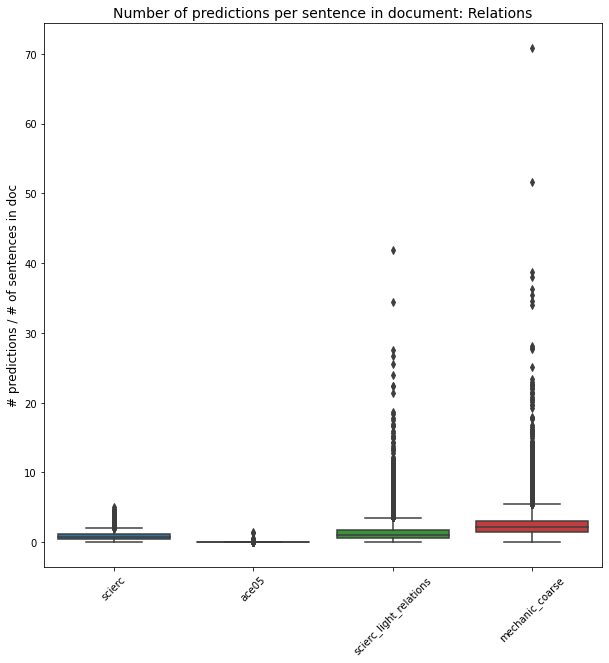

In [58]:
# Sentence plot relations
## Make dataframe
sentence_rels_df = pd.DataFrame({'scierc':scierc_plot_data['scierc_rels_norm_sents'],
                           'ace05':ace05_plot_data['ace05_rels_norm_sents'],
                           'scierc_light_relations':scierc_light_plot_data['scierc_light_rels_norm_sents'],
                           'mechanic_coarse':mechanic_coarse_plot_data['mechanic_coarse_rels_norm_sents']})

## Make plot
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=sentence_rels_df)
ax.set_title('Number of predictions per sentence in document: Relations', fontsize=14)
ax.set_ylabel('# predictions / # of sentences in doc', fontsize=12)
ax.set_xticklabels(sentence_rels_df.columns.values.tolist(), rotation=45)

[Text(0, 0, 'scierc'),
 Text(1, 0, 'ace05'),
 Text(2, 0, 'scierc_light'),
 Text(3, 0, 'genia'),
 Text(4, 0, 'genia_light'),
 Text(5, 0, 'mechanic_coarse')]

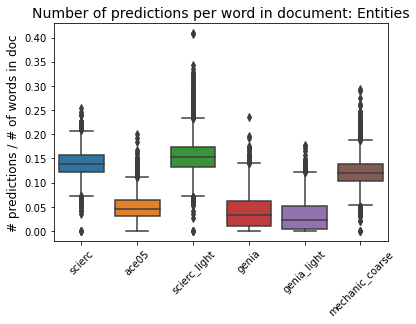

In [55]:
# Word plot entities
## Make dtaframe 
words_ents_df = pd.DataFrame({'scierc':scierc_plot_data['scierc_ents_norm_words'],
                           'ace05':ace05_plot_data['ace05_ents_norm_words'],
                           'scierc_light':scierc_light_plot_data['scierc_light_ents_norm_words'],
                           'genia':genia_plot_data['genia_ents_norm_words'],
                           'genia_light':genia_light_plot_data['genia_light_ents_norm_words'],
                           'mechanic_coarse':mechanic_coarse_plot_data['mechanic_coarse_ents_norm_words']})
## Make plot
ax = sns.boxplot(data=words_ents_df)
ax.set_title('Number of predictions per word in document: Entities', fontsize=14)
ax.set_ylabel('# predictions / # of words in doc', fontsize=12)
ax.set_xticklabels(words_ents_df.columns.values.tolist(), rotation=45)

[Text(0, 0, 'scierc'),
 Text(1, 0, 'ace05'),
 Text(2, 0, 'scierc_light'),
 Text(3, 0, 'mechanic_coarse')]

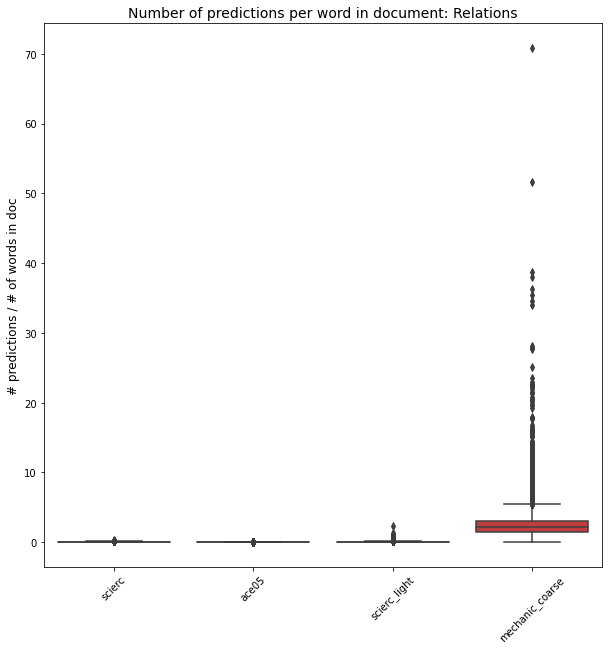

In [57]:
# Word plot relations
## Make dataframe 
words_rels_df = pd.DataFrame({'scierc':scierc_plot_data['scierc_rels_norm_words'],
                           'ace05':ace05_plot_data['ace05_rels_norm_words'],
                           'scierc_light':scierc_light_plot_data['scierc_light_rels_norm_words'],
                           'mechanic_coarse':mechanic_coarse_plot_data['mechanic_coarse_rels_norm_sents']})

## Make plot
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=words_rels_df)
ax.set_title('Number of predictions per word in document: Relations', fontsize=14)
ax.set_ylabel('# predictions / # of words in doc', fontsize=12)
ax.set_xticklabels(words_rels_df.columns.values.tolist(), rotation=45)

Also want to plot a bar plot with the total numbers of each type of prediction for each model.

In [60]:
# Get numbers for each
stats_dict = {}
for model_stat_df in [scierc_ent_stats, ace05_ent_stats, scierc_light_ent_stats, genia_ent_stats, genia_light_ent_stats, mechanic_coarse_ent_stats]:
    stats_dict[model_stat_df['model_name'].loc[0] + '_ents'] = [model_stat_df['total_preds'].loc[0]]
    
for model_stat_df in [scierc_rels_stats, ace05_rels_stats, scierc_light_rels_stats, mechanic_coarse_ent_stats]:
    stats_dict[model_stat_df['model_name'].loc[0] + '_rels'] = [model_stat_df['total_preds'].loc[0]]

total_stats_df = pd.DataFrame(stats_dict)
total_stats_df.head()

,scierc_ents,ace05_ents,scierc_light_ents,genia_ents,genia_light_ents,mechanic_coarse_ents,scierc_rels,ace05_rels,scierc_light_rels,mechanic_coarse_rels
0,237206,82670,301015,68203,54658,204867,65338,1040,112563,204867


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'scierc_ents'),
  Text(1, 0, 'ace05_ents'),
  Text(2, 0, 'scierc_light_ents'),
  Text(3, 0, 'genia_ents'),
  Text(4, 0, 'genia_light_ents'),
  Text(5, 0, 'mechanic_coarse_ents'),
  Text(6, 0, 'scierc_rels'),
  Text(7, 0, 'ace05_rels'),
  Text(8, 0, 'scierc_light_rels'),
  Text(9, 0, 'mechanic_coarse_rels')])

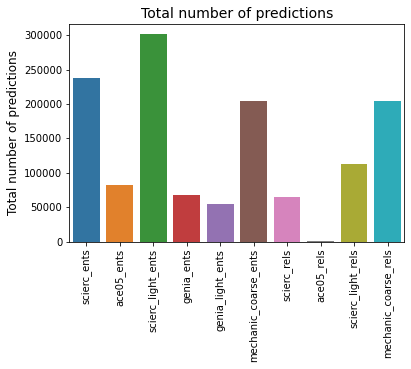

In [61]:
# Plot 
ax = sns.barplot(data=total_stats_df)
ax.set_title('Total number of predictions', fontsize=14)
ax.set_ylabel('Total number of predictions', fontsize=12)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'scierc_entities'),
  Text(1, 0, 'ace05_entities'),
  Text(2, 0, 'scierc_light_entities'),
  Text(3, 0, 'genia_entities'),
  Text(4, 0, 'genia_light_entities'),
  Text(5, 0, 'scierc_relations'),
  Text(6, 0, 'ace05_relations'),
  Text(7, 0, 'scierc_light_relations')])

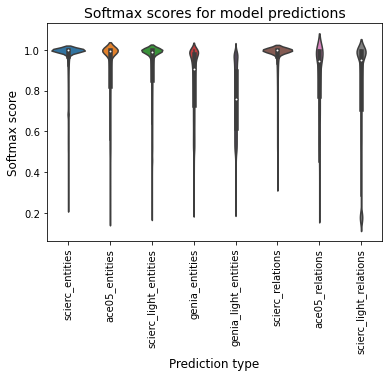

In [49]:
# Softmax plot 
## Make dataframe
lists =  [scierc_ents_softmax, ace05_ents_softmax, scierc_light_ents_softmax, genia_ents_softmax, genia_light_ents_softmax, scierc_rels_softmax, ace05_rels_softmax, scierc_light_rels_softmax]
list_names = ['scierc_entities', 'ace05_entities', 'scierc_light_entities', 'genia_entities', 'genia_light_entities','scierc_relations', 'ace05_relations', 'scierc_light_relations']
index_col = []
softmax_col = []
for name, data in zip(list_names, lists):
    for item in data:
        index_col.append(name)
        softmax_col.append(item)

long_softmax_df = pd.DataFrame({'prediction_type':index_col, 'softmax_score':softmax_col})

## Make plot
ax = sns.violinplot(x='prediction_type', y='softmax_score', data=long_softmax_df)
ax.set_title('Softmax scores for model predictions', fontsize=14)
ax.set_xlabel('Prediction type', fontsize=12)
ax.set_ylabel('Softmax score', fontsize=12)
plt.xticks(rotation=90)

In [50]:
# Get mean and median for each 
grouped_df = long_softmax_df.groupby('prediction_type')
grouped_df.mean()

,softmax_score
prediction_type,
ace05_entities,0.883853
ace05_relations,0.867150
genia_entities,0.841535
genia_light_entities,0.750129
scierc_entities,0.940701
scierc_light_entities,0.897008
scierc_light_relations,0.805659
scierc_relations,0.948415


In [51]:
grouped_df.median()

,softmax_score
prediction_type,
ace05_entities,0.99210
ace05_relations,0.94690
genia_entities,0.90690
genia_light_entities,0.75665
scierc_entities,0.99980
scierc_light_entities,0.98960
scierc_light_relations,0.94810
scierc_relations,0.99970


In [24]:
# Gibberish data softmax 
## Read in the data 
import os 

file_list = ['../data/first_manuscript_data/dygiepp/pretrained_output/withCoref/scierc/gibberishAll_scierc_predictions.jsonl',
             '../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/scierc-light/gibberishAll_scierc-light_predictions.jsonl',
             '../data/first_manuscript_data/dygiepp/pretrained_output/withCoref/genia/gibberishAll_genia_predictions.jsonl',
             '../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/genia-light/gibberishAll_genia-light_predictions.jsonl',
             '../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/ace05/gibberishAll_ace05_predictions.jsonl',
             '../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/mechanic-granular/gibberishAll_mechanic-granular_predictions.jsonl',
             '../data/first_manuscript_data/dygiepp/pretrained_output/lightweight/mechanic-coarse/gibberishAll_mechanic-coarse_predictions.jsonl']

file_short_names = [os.path.basename(file_name).split('_')[1] for file_name in file_list]

gibberish_softmax = {}
for file_short_name, file_name in zip(file_short_names, file_list):
    # Read in results
    results = read_predictions(file_name)
    # Get softmax scores 
    if 'genia' not in file_short_name:
        ent_softmax, rel_softmax = get_softmax(results)
        gibberish_softmax[f'{file_short_name}_entities'] = ent_softmax
        gibberish_softmax[f'{file_short_name}_relations'] = rel_softmax
    else:
        ent_softmax = get_softmax_no_rels(results)
        gibberish_softmax[f'{file_short_name}_entities'] = ent_softmax

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'scierc_entities'),
  Text(1, 0, 'scierc_relations'),
  Text(2, 0, 'scierc-light_entities'),
  Text(3, 0, 'scierc-light_relations'),
  Text(4, 0, 'genia_entities'),
  Text(5, 0, 'genia-light_entities'),
  Text(6, 0, 'ace05_entities'),
  Text(7, 0, 'ace05_relations')])

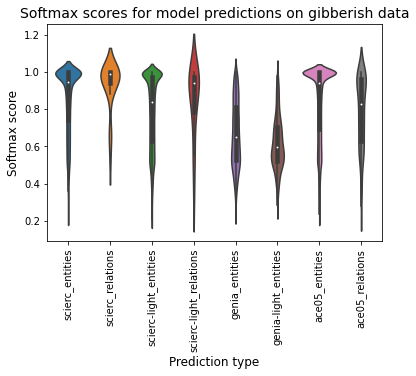

In [25]:
# Make gibberish softmax plot 
## Mechanic gets left out here because it has no data 
index_col_gib = []
softmax_col_gib = []
for key, value in gibberish_softmax.items():
    for item in value:
        index_col_gib.append(key)
        softmax_col_gib.append(item)
        
long_softmax_gib = pd.DataFrame({'prediction_type':index_col_gib, 'softmax_score':softmax_col_gib})

## Make plot
ax = sns.violinplot(x='prediction_type', y='softmax_score', data=long_softmax_gib)
ax.set_title('Softmax scores for model predictions on gibberish data', fontsize=14)
ax.set_xlabel('Prediction type', fontsize=12)
ax.set_ylabel('Softmax score', fontsize=12)
plt.xticks(rotation=90)

In [22]:
grouped_gib = long_softmax_gib.groupby('prediction_type')
grouped_gib.mean()

,softmax_score
prediction_type,
ace05_ents,0.840919
ace05_rels,0.784788
genia-light_ents,0.617316
genia_ents,0.667300
scierc-light_ents,0.789846
scierc-light_rels,0.849458
scierc_ents,0.855989
scierc_rels,0.927753


In [23]:
grouped_gib.median()

,softmax_score
prediction_type,
ace05_ents,0.9396
ace05_rels,0.8269
genia-light_ents,0.5951
genia_ents,0.6497
scierc-light_ents,0.8377
scierc-light_rels,0.9425
scierc_ents,0.9465
scierc_rels,0.9863
